In [1]:
from sympy.physics.mechanics import *
from sympy import symbols, trigsimp
from numpy import deg2rad, rad2deg, array, zeros, linspace, pi
from scipy.integrate import odeint

from pydy.codegen.ode_function_generators import generate_ode_function

from sympy.physics.vector import init_vprinting
import matplotlib.pyplot as plt

### Overview of how to use sympy and PyDy:
Following tutorial: https://onlinelibrary.wiley.com/doi/epdf/10.1002/cae.22438?af=R

Kane's Method Roadmap:
- Define generalized coordinates/speeds
- For each rigid body B, find w_b_n and v_b_n
- Find partial velocities for each degree of freedom (v_r_n_b, w_r_n_b)
- Find expression for acceleration for each rigid body
- Find active torques/forces acting on each body
- Assemble Newton's/Euler's equations (F-ma = 0) for each rigid body
- For each generalized speed, project into its direction and sum


In [2]:
# # The system is a series of bodies chained together 
# # Initialize symbolic variables
# L, m, g, a, M, c1, c2, Ia, Ib = symbols('L m g a M c1 c2 Ia Ib')
# # L, a, c1, c2 are lengths and coordinates
# # g is acceleration due to gravity
# # m and M are masses
# # Ia and Ib are moments of inertia

# # Describe Kinematics/Configuration space of the system
# theta, phi = dynamicsymbols('theta phi') # declare them as dynamic symbols because they are time-dependent variables
# theta_d, phi_d = dynamicsymbols('theta phi', 1)

# # Specify angular velocities and accelerations
# omega_1, omega_2 = dynamicsymbols('omega_1 omega_2')
# omega_1_d, omega_2_d = dynamicsymbols('omega_1 omega_2', 1)

# # Define reference frames
# N = ReferenceFrame('N') # inertial reference frame
# # Define a rotating body-fixed frame, define it with respect to frame N
# A = N.orientnew('A', 'Axis', [theta, N.z])
# # A.x, A.y, A.z are the unit vectors along x, y, and z axes
# # Define a B axis as well, described with respect to A
# # B is fixed to the second constituent body of the chain
# B = A.orientnew('B', 'Axis', [phi, N.z])

# # Angular velocity of the first constituent body is the angular velocity of the frame fixed to it
# A.set_ang_vel(N, omega_L * N.z) # First argument N implies that the prescribed angular velocity is the angular velocity wrt inertial frame N

# # Angular velocity of B
# B.set_ang_vel(N, omega_P * N.z)

# # Define locations (position vectors) and velocities of all significant points
# # Points such as CoM, connections between two bodies, locations where external forces and moments are applied


# # Origin of inertial frame N
# O = Point('O')
# # Position vector of any point R wrt point P
# R = P.locatenew('R', -a*B.y) # to reach R from P, one has to move a distance 'a' in the opposite direction of the y coordinate axis of reference frame B

# # Origin is a fixed point, velocity must be set to zero
# O.set_vel(N, 0)

# # velocities of other points can be set using v2pt_theory
# P.v2pt_theory(O, N, A) # abs vel of point P is the velocity of point O plus velocity of point P wrt point O. 
# # Points P and O are connected by the body-fixed frame A
# # When the second argument is present (N) and is the inertial ref frame, the computed velocity is the absolute one

# # To specify system constraints (if any)
# # sympy mechanics automatically models hinges when a point of contact of two rigid bodies in a chain is specified

# zero = Q.pos_from(O) + O.pos_from(R) # vector equation
# q_cons = [zero & N.x, zero & N.y] # configuration constraints, & operator carries out dot product operation
# dzero = time_derivative(zero, N) # time derivative of given vector equation
# u_cons = [dzero & N.x, dzero & N.y] # velocity constraints

# # To declare Kane's Method object

# # List generalized coordinates
# # Linear and angular speeds
# # Relations between actual speeds
# # Generalized speeds

# # The system has two generalized coordinates (theta and phi)
# # Two generalized speeds (theta_d, phi_d)
# # Angular speeds of the body-fixed frames are omega_L and omega_P
# coordinates = [theta, phi]
# speeds = [omega_L, omega_P]

# # Kinematic Differential Equations
# # omega_L - theta_d = 0
# # omega_P - phi_d = 0
# kde = [omega_L - theta_d, omega_P - phi_d]

# # Initialize Kane's object
# kane = KanesMethod(N, coordinates, speeds, kde)

# # To define objects for all the particles and rigid bodies in the system along with mass and inertia
# # Define all forces acting on the system and their points of application

# # Rigid body mass and inertia
# ita = inertia(A, 0, 0, Ia) # defined about a point in the body-fixed axis
# i1 = (ita, G) # G is the point about which the moment of inertia is defined

# Link1 = RigidBodY('Link1', G, A, m, i1) # Rigid body object
# # CoM is at G, A is the body-fixed frame, m and i1 are the mass and moment of inertia

# # to build up a multi-body system we can use a list as the object
# Bodies = [Link1, Link2, Link3]

# # Externelly applied forces
# # represented as a tuple of the point of application and the force vector
# F1 = (P, a*N.x + b*N.y) # force vector applied at point P
# Forces = [F1, F2, F3]

# # To obtain symbolic expressions for generalized active and inertia forces using kanes equations function
# # Subsequently generate the mass matrix and forcing vector

# fr, frstar = kanes.kanes_equations(Bodies, Forces)
# trigsimp(fr + frstar)
# # Mass matrix
# mm = trigsimp(kane.mass_matrix_full)
# fm = trigsimp(kane.forcing_full)

# # to simulate, generate RHS and integrate for results
# # RHS is a vector that is a function of generalized coordinates, speeds, applied forces, and time
# # Replace symbolic values with numerical ones
# constants = [L, c1, m, Ia, a, c2, M, Ib, g]
# # Generate ODE function 
# rhs = generate_ode_function(fm, coordinates, speeds, constants, mass_matrix = mm)
# # Initial conditions 
# x0 = zeros(4)
# # numerical values 1:1 with the symbolic constants list
# numerical_constants = array([12, 6, 0, 0, 6, 3, 10, 60, 9.81])

# rhs(x0, 0.0, numerical_constants)
# t = linspace(0, 50, 1000)

# y = odeint(rhs, x0, t, args=(numerical_constants))




###  Example 1: Square plate suspended from a fixed support by the means of 2 springs and two adjacent vertices

One of the strings is cut instantaneously without any change in the configurations of the other components in the system

The objective is to simulate the motion that the plate will exhibit when one of the strings is cut

![Example 1 Image](imgs/example1.PNG)


Some notes about the system:
- Tension in the string will always be positive and string will remain taut (Can treat string as a rigid link)
- Will assume this as a massless link/string
- Joints considered frictionless


In [105]:
# Define constants
L = symbols('L') # length of link
a = symbols('a') # Length of block
g = symbols('g') # Gravitational Constant
m_link = symbols('m_link') # mass of link
m_block = symbols('m_block') # mass of block

# Describe kinematic variables
# Angles and their derivatives
theta, phi = dynamicsymbols('theta phi') # declare them as dynamic symbols because they are time-dependent variables
theta_d, phi_d = dynamicsymbols('theta phi', 1)

# Define reference frames
# Inertial
Nrf = ReferenceFrame('Nrf')
Grf = Nrf.orientnew('Grf', 'Axis', [theta, Nrf.z])
Crf = Nrf.orientnew('Crf', 'Axis', [phi, Nrf.z])

# set angular velocity of these frames 

# Generalized speeds
u1, u2 = dynamicsymbols('u1 u2')
u1d, u2d = dynamicsymbols('u1 u2', 1)
# w_g/n = theta_d * N.z
Grf.set_ang_vel(Nrf, u1 * Nrf.z)
Crf.set_ang_vel(Nrf, u2 * Nrf.z)

# Define locations
O = Point('O')

P = O.locatenew('P', -L * Grf.y)
G = O.locatenew('G', (-L/2) * Grf.y)
C = P.locatenew('C', (a/2) * (Crf.x - Crf.y))
R = P.locatenew('R', -a*Crf.y)

# Now define point velocities 
O.set_vel(Nrf, 0)
G.v2pt_theory(O, Nrf, Grf)
P.v2pt_theory(O, Nrf, Grf)
C.v2pt_theory(P, Nrf, Crf)
R.v2pt_theory(P, Nrf, Crf)
# Gather everything into lists
coordinates = [theta, phi]
speeds = [u1, u2]

# form kinematic differential equations
kde = [u1 - theta_d, u2 - phi_d]

# Initialize Kane's object
kane = KanesMethod(Nrf, coordinates, speeds, kde)

# Inertia dynamics
Ig, Ic = symbols('I_G I_C')

ita = inertia(Grf, 0, 0, Ig)
itb = inertia(Crf, 0, 0, Ic)

i1 = (ita, G)
i2 = (itb, C)

# Define rigid body objects
link = RigidBody('Link', G, Grf, m_link, i1)
block = RigidBody('Block', C, Crf, m_block, i2)

# Define forces and point of application

# Gravity on each rigid body
g_link = (G, -m_link*g*Nrf.y)
g_block = (C, -m_block*g*Nrf.y)
loads = [g_link, g_block]
bodies = [link, block]

# Get equations
fr, frstar = kane.kanes_equations(bodies, loads)
trigsimp(fr + frstar)





Matrix([
[-I_G*Derivative(u1(t), t) - L**2*m_block*Derivative(u1(t), t) - L**2*m_link*Derivative(u1(t), t)/4 + sqrt(2)*L*a*m_block*u2(t)**2*cos(-phi(t) + theta(t) + pi/4)/2 - sqrt(2)*L*a*m_block*sin(-phi(t) + theta(t) + pi/4)*Derivative(u2(t), t)/2 - L*g*m_block*sin(theta(t)) - L*g*m_link*sin(theta(t))/2],
[                                                  -I_C*Derivative(u2(t), t) - sqrt(2)*L*a*m_block*u1(t)**2*cos(-phi(t) + theta(t) + pi/4)/2 - sqrt(2)*L*a*m_block*cos(phi(t) - theta(t) + pi/4)*Derivative(u1(t), t)/2 - a**2*m_block*Derivative(u2(t), t)/2 - sqrt(2)*a*g*m_block*sin(phi(t) + pi/4)/2]])

In [ ]:
trigsimp(C.pos_from(O).dot(Nrf.x))

L*sin(theta(t)) + sqrt(2)*a*sin(phi(t) + pi/4)/2

In [ ]:
trigsimp(C.pos_from(O).dot(Nrf.y))

-L*cos(theta(t)) - sqrt(2)*a*cos(phi(t) + pi/4)/2

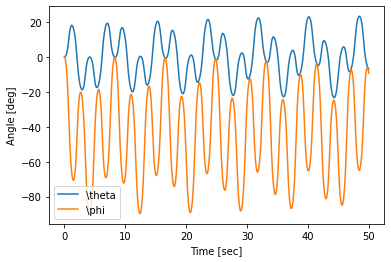

In [ ]:
# Obtain mass matrix and forcing vector
mm = trigsimp(kane.mass_matrix_full)
fm = trigsimp(kane.forcing_full)

# List of all constants
constants = [L, m_link, Ig, a, m_block, Ic, g]
numerical_constants = array([12, 0, 0, 6, 10, 60, 9.81])

# Generate RHS
rhs = generate_ode_function(fm, coordinates, speeds, constants, mass_matrix = mm)

# Define initial conditions
x0 = zeros(4)
# Time
t = linspace(0, 50, 1000)

rhs(x0, 0.0, numerical_constants)

y = odeint(rhs, x0, t, args=(numerical_constants, ))

plt.plot(t, rad2deg(y[:,:2])) # first two columns of y contain theta and phi
plt.xlabel('Time [sec]')
plt.ylabel('Angle [deg]')
plt.legend(["{}".format(vlatex(c)) for c in coordinates])

In [ ]:
# 3D Vs
from pydy.viz.shapes import Cylinder, Cube
import pydy.viz
from pydy.viz.visualization_frame import VisualizationFrame
import pydy.viz.scene
from pydy.viz.scene import Scene
import pythreejs

constants_dict = dict(zip(constants, numerical_constants))

link_shape = Cylinder(name='LinkShape', length=constants_dict[L], radius = 0.1, color = 'gray')
block_shape = Cube(name='BlockShape', length=constants_dict[a], color = 'blue')
lvf = VisualizationFrame('Link', Grf, G, link_shape)
cvf = VisualizationFrame('Block', Crf, C, block_shape)

scene = Scene(Nrf, O)
scene.visualization_frames = [lvf, cvf]
scene.states_symbols = coordinates + speeds
scene.constants = constants_dict
scene.states_trajectories = y
scene.times = t

scene.display_jupyter(axes_arrow_length=5.0)
#scene.display()
#scene.display_jupyter(axes_arrow_length=None)

### Example 2: Rolling ball

A disc of mass m_0 and radius r having an eccentrically attached mass is rolling down a plane inclined at an angle phi with the horizontal. Disc was given an initial clockwise rotation

Assume sufficient friction and no slip occurs when disc is rolling. Only force acting on the system is gravity acting in the negative y-direction wrt inertial reference frame

![Example 1 image](imgs/example2.PNG)